STATIC ANALYSE

In [109]:
import numpy as np
import math
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=320, suppress=True)

# All calculations in this file were conducted based on descriptions presented in book: 
# Inzynierskie metody analizy numerycznej i planowanie eksperymentu, 
# Ireneucz Czajka, Andrzej Gołaś, AGH, Krakow 2017.

c_a = np.loadtxt('coordinates_array.txt',delimiter = ' ')  # inupt coordinates array
c_a = c_a.astype(int)

p_a = np.loadtxt('points array.txt',delimiter = ' ') # input points array
p_a = p_a.astype(int)

# PRIMARY SETTINGS AND CALCULATIONS

l=[] # element length array

for a in range(1):
    for n in range(len(p_a)):
        x = ((c_a[p_a[n][a + 1]][0]) - (c_a[p_a[n][a]][0]))
        y = ((c_a[p_a[n][a + 1]][1]) - (c_a[p_a[n][a]][1]))
        l.append(math.sqrt((x**2)+(y**2)))

list_sin = [] # sinus angle between elements list
list_cos = [] # cosinus angle between elements list
angle = []

for a in range(1):
    for n in range(len(p_a)):
        list_cos.append(((c_a[p_a[n][a + 1]][0]) - (c_a[p_a[n][a]][0]))/l[n])
        list_sin.append(((c_a[p_a[n][a + 1]][1]) - (c_a[p_a[n][a]][1]))/l[n])

k_l = [] # stiffness array of an element in the local reference system
k_g = [] # stiffness array of an element in the global reference system
A = 8e-6 # cross section area
E = 2e11 # Young modulus (for steel in Pa)

k_0 = np.array([[1, 0, -1, 0], [0, 0, 0, 0], [-1, 0, 1, 0], [0, 0, 0, 0]]) # general stiffness matrix of a two-dimensional rod element

for e in range(len(p_a)):
    k_l.append(np.multiply((A*E)/l[e], k_0)) # local stiffness array of an element
    DC = np.zeros((4, 4))  # directional cosinus array
    DC_trans = DC.transpose()
    for m in range(0, 2):
        DC[2 * m, 2 * m] = list_cos[e]
        DC[2 * m, 2 * m + 1] = list_sin[e]
        DC[2 * m + 1, 2 * m] = -list_sin[e]
        DC[2 * m + 1, 2 * m + 1] = list_cos[e]
    k_g.append(DC_trans @ k_l[e] @ DC)

In [110]:
# AGGREGATION MECHANISM

k_o = [] # stiffness array in the global reference system

for e in range(len(p_a)):
    k_o1 = np.zeros(((2 * len(c_a)), (2 * len(c_a))))
    x1 = p_a[e][0]
    y1 = p_a[e][1]
    k_o1[np.ix_([x1+x1, x1+(x1+1)], [x1+x1, x1+(x1+1)])] = (k_g[e])[np.ix_([0, 1], [0, 1])] 
    k_o1[np.ix_([y1+y1, y1+(y1+1)], [y1+y1, y1+(y1+1)])] = (k_g[e])[np.ix_([2, 3], [2, 3])] 
    k_o1[np.ix_([x1+x1, x1+(x1+1)], [y1+y1, y1+(y1+1)])] = (k_g[e])[np.ix_([0, 1], [2, 3])] 
    k_o1[np.ix_([y1+y1, y1+(y1+1)], [x1+x1, x1+(x1+1)])] = (k_g[e])[np.ix_([2, 3], [0, 1])] 
    k_o.append(k_o1)

# [K_agr] = [ko0−1] + [ko0−3] + [ko0−4] + [ko1−2] + [ko1−3] ...

K_agr = 0 
num = 0

while(num < len(k_o)):
    K_agr = K_agr + k_o[num]
    num += 1

print('Final stiffness array in the global reference system - after aggregation:\n\n', K_agr)

Final stiffness array in the global reference system - after aggregation:

 [[ 2165685.425   565685.425 -1600000.           0.           0.           0.     -565685.425  -565685.425        0.           0.   ]
 [  565685.425  2165685.425        0.           0.           0.           0.     -565685.425  -565685.425        0.    -1600000.   ]
 [-1600000.           0.     2000000.           0.     -400000.           0.           0.           0.           0.           0.   ]
 [       0.           0.           0.     1600000.           0.           0.           0.    -1600000.           0.           0.   ]
 [       0.           0.     -400000.           0.      765230.118   -91307.529  -365230.118    91307.529        0.           0.   ]
 [       0.           0.           0.           0.      -91307.529    22826.882    91307.529   -22826.882        0.           0.   ]
 [ -565685.425  -565685.425        0.           0.     -365230.118    91307.529  2530915.543   474377.896 -1600000.           

In [111]:
# BOUNDARY CONDITIONS

P_o = np.zeros((10,1))
load_point = 2 # number of the loaded node
load_direction = 1 # direction of applied load (x = 0, y = 1)
P_o[2*int(load_point)+int(load_direction),0] = -25*10**3 # load equal to 25 kN

print('Load array: \n', P_o)

# Dirichlet boundary conditions is implemented by setting zero in the row and column of the stiffness array corresponding
# to a degree of freedom we want to take away.
# On the main diagonal, at the intersection of the aforementioned row and column, a value of 1 is setted, 
# zeroing the load vector for the corresponding degrees of freedom. 
# This is done because taking away a degree of freedom means zero displacements in a given degree of freedom.

# setting zeros

K_agr[:,6] = 0
K_agr[:,7] = 0
K_agr[6,:] = 0
K_agr[7,:] = 0
K_agr[:,1] = 0
K_agr[1,:] = 0

# setting ones

for i in range(len(K_agr)):
    if K_agr[i][i] == 0:
        K_agr[i][i] = 1
    else:
        continue

print('\nStiffness array in the global reference system - after beeing constrained:\n', K_agr)

Load array: 
 [[     0.]
 [     0.]
 [     0.]
 [     0.]
 [     0.]
 [-25000.]
 [     0.]
 [     0.]
 [     0.]
 [     0.]]

Stiffness array in the global reference system - after beeing constrained:
 [[ 2165685.425        0.    -1600000.           0.           0.           0.           0.           0.           0.           0.   ]
 [       0.           1.           0.           0.           0.           0.           0.           0.           0.           0.   ]
 [-1600000.           0.     2000000.           0.     -400000.           0.           0.           0.           0.           0.   ]
 [       0.           0.           0.     1600000.           0.           0.           0.           0.           0.           0.   ]
 [       0.           0.     -400000.           0.      765230.118   -91307.529        0.           0.           0.           0.   ]
 [       0.           0.           0.           0.      -91307.529    22826.882        0.           0.           0.           0.   ]



Displacement of particular nodes: 
 [[-0.177]
 [ 0.   ]
 [-0.239]
 [ 0.   ]
 [-0.489]
 [-3.052]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]]


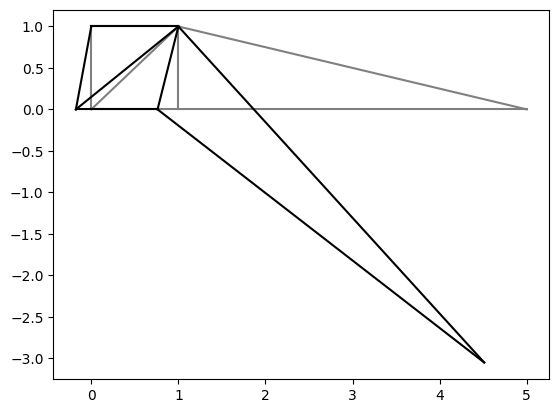

In [112]:
# SOLUTION

u_o = np.linalg.inv(K_agr) @ P_o

print('\nDisplacement of particular nodes: \n', u_o)

# results plot

plt.plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
plt.plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
plt.plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
plt.plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
plt.plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
plt.plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
plt.plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

plt.plot([c_a[0,0] + u_o[0,0],c_a[1,0] + u_o[2,0]],[c_a[0,1],c_a[1,1]],'black')
plt.plot([c_a[1,0] + u_o[2,0],c_a[2,0] + u_o[4,0]],[c_a[1,1],c_a[2,1] + u_o[5,0]],'black')
plt.plot([c_a[2,0] + u_o[4,0],c_a[3,0]],[c_a[2,1] + u_o[5,0],c_a[3,1]],'black')
plt.plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'black')
plt.plot([c_a[4,0],c_a[0,0] + u_o[0,0]],[c_a[4,1],c_a[0,1]],'black')
plt.plot([c_a[0,0] + u_o[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'black')
plt.plot([c_a[3,0],c_a[1,0] + u_o[2,0]],[c_a[3,1],c_a[1,1]],'black')

plt.show()

DYNAMIC ANALYSIS

In [113]:
# AGGREGATION MECHANISM

p = 7860 # material density

m_0 = np.array([[2, 0, 1, 0], [0, 2, 0, 1], [1, 0, 2, 0], [0, 1, 0, 2]]) # general inertia matrix of a two-dimensional rod element
m_g = [] # Inertia arrays in the global reference system

for e in range(len(p_a)):
    m_g.append(np.multiply((p*A*l[e])/6, m_0))

m_o = [] # inertia arrays for particular elements

for e in range(len(p_a)):
    m_o1 = np.zeros(((2 * len(c_a)), (2 * len(c_a))))
    x1 = p_a[e][0]
    y1 = p_a[e][1]
    m_o1[np.ix_([x1+x1, x1+(x1+1)], [x1+x1, x1+(x1+1)])] = (m_g[e])[np.ix_([0, 1], [0, 1])]
    m_o1[np.ix_([y1+y1, y1+(y1+1)], [y1+y1, y1+(y1+1)])] = (m_g[e])[np.ix_([2, 3], [2, 3])]
    m_o1[np.ix_([x1+x1, x1+(x1+1)], [y1+y1, y1+(y1+1)])] = (m_g[e])[np.ix_([0, 1], [2, 3])]
    m_o1[np.ix_([y1+y1, y1+(y1+1)], [x1+x1, x1+(x1+1)])] = (m_g[e])[np.ix_([2, 3], [0, 1])]
    m_o.append(m_o1)

M_agr = 0
num = 0

while(num < len(m_o)):
    M_agr = M_agr + m_o[num]
    num += 1

print('\nInertia array in the global reference system - after aggregation:\n', M_agr)


Inertia array in the global reference system - after aggregation:
 [[0.072 0.    0.01  0.    0.    0.    0.015 0.    0.01  0.   ]
 [0.    0.072 0.    0.01  0.    0.    0.    0.015 0.    0.01 ]
 [0.01  0.    0.126 0.    0.042 0.    0.01  0.    0.    0.   ]
 [0.    0.01  0.    0.126 0.    0.042 0.    0.01  0.    0.   ]
 [0.    0.    0.042 0.    0.17  0.    0.043 0.    0.    0.   ]
 [0.    0.    0.    0.042 0.    0.17  0.    0.043 0.    0.   ]
 [0.015 0.    0.01  0.    0.043 0.    0.158 0.    0.01  0.   ]
 [0.    0.015 0.    0.01  0.    0.043 0.    0.158 0.    0.01 ]
 [0.01  0.    0.    0.    0.    0.    0.01  0.    0.042 0.   ]
 [0.    0.01  0.    0.    0.    0.    0.    0.01  0.    0.042]]


In [114]:
# BOUNDARY CONDITIONS
# same settings as described earlier

M_agr[:,6] = 0
M_agr[:,7] = 0
M_agr[6,:] = 0
M_agr[7,:] = 0
M_agr[:,1] = 0
M_agr[1,:] = 0

for i in range(len(M_agr)):
    if M_agr[i][i] == 0:
        M_agr[i][i] = 1
    else:
        continue

print('\nInertia array in the global reference system - after beeing constrained:\n', M_agr)


Inertia array in the global reference system - after beeing constrained:
 [[0.072 0.    0.01  0.    0.    0.    0.    0.    0.01  0.   ]
 [0.    1.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.01  0.    0.126 0.    0.042 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.126 0.    0.042 0.    0.    0.    0.   ]
 [0.    0.    0.042 0.    0.17  0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.042 0.    0.17  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.01  0.    0.    0.    0.    0.    0.    0.    0.042 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.042]]


In [115]:
# SOLUTION

A_eig = np.linalg.inv(M_agr) @ K_agr
eigenvalues, eigenvectors = np.linalg.eig(A_eig)
# eigenvalues - eigenvalues of vibrations
print('\nVetor values of vibrations: \n', eigenvectors)

f = np.sqrt(eigenvalues) / (2 * math.pi)
f = np.sort(f)
threshold = 1
mask = f > threshold
f = f[mask]
f = np.vstack(f)

print('\n Proprietary vibration frequencies [Hz]: \n', f)


Vetor values of vibrations: 
 [[ 0.693 -0.213  0.012  0.575  0.482  0.059  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     1.     0.     0.     0.   ]
 [-0.383  0.227  0.008  0.533  0.606  0.08   0.     0.     0.     0.   ]
 [ 0.001 -0.001 -0.97   0.022 -0.011  0.001  0.     0.     0.     0.   ]
 [ 0.121 -0.081 -0.018 -0.617  0.605  0.161  0.     0.     0.     0.   ]
 [-0.001  0.001  0.242  0.035 -0.186  0.982  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     1.     0.   ]
 [-0.598 -0.947  0.002  0.04   0.006  0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     1.   ]]

 Proprietary vibration frequencies [Hz]: 
 [[  34.235]
 [ 216.564]
 [ 459.187]
 [ 592.86 ]
 [ 956.694]
 [ 983.263]
 [1166.717]]


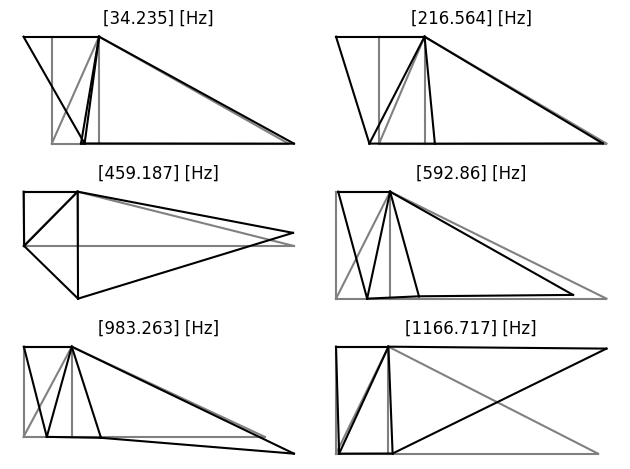

In [116]:
# result plot
# scheme of solution presentation: [[x1, x2]] [[y1, y2]]

ev_s = eigenvectors

fig, freq = plt.subplots(3,2)

freq[0, 0].plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
freq[0, 0].plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
freq[0, 0].plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
freq[0, 0].plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
freq[0, 0].plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
freq[0, 0].plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
freq[0, 0].plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

freq[0, 0].plot([c_a[0,0] + ev_s[0,0],c_a[1,0] + ev_s[2,0]], [c_a[0,1] + ev_s[1,0],c_a[1,1] + ev_s[3,0]],'black')
freq[0, 0].plot([c_a[1,0] + ev_s[2,0],c_a[2,0] + ev_s[4,0]], [c_a[1,1] + ev_s[3,0],c_a[2,1] + ev_s[5,0]],'black')
freq[0, 0].plot([c_a[2,0] + ev_s[4,0],c_a[3,0] + ev_s[6,0]], [c_a[2,1] + ev_s[5,0],c_a[3,1] + ev_s[7,0]],'black')
freq[0, 0].plot([c_a[3,0] + ev_s[6,0],c_a[4,0] + ev_s[8,0]], [c_a[3,1] + ev_s[7,0],c_a[4,1] + ev_s[9,0]],'black')
freq[0, 0].plot([c_a[4,0] + ev_s[8,0],c_a[0,0] + ev_s[0,0]], [c_a[4,1] + ev_s[9,0],c_a[0,1] + ev_s[1,0]],'black')
freq[0, 0].plot([c_a[0,0] + ev_s[0,0],c_a[3,0] + ev_s[6,0]], [c_a[0,1] + ev_s[1,0],c_a[3,1] + ev_s[7,0]],'black')
freq[0, 0].plot([c_a[3,0] + ev_s[6,0],c_a[1,0] + ev_s[2,0]], [c_a[3,1] + ev_s[7,0],c_a[1,1] + ev_s[3,0]],'black')

freq[0, 0].set_title(str(f[0]) + " [Hz]")

freq[0, 1].plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
freq[0, 1].plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
freq[0, 1].plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
freq[0, 1].plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
freq[0, 1].plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
freq[0, 1].plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
freq[0, 1].plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

freq[0, 1].plot([c_a[0,0] + ev_s[0,1],c_a[1,0] + ev_s[2,1]], [c_a[0,1] + ev_s[1,1],c_a[1,1] + ev_s[3,1]],'black')
freq[0, 1].plot([c_a[1,0] + ev_s[2,1],c_a[2,0] + ev_s[4,1]], [c_a[1,1] + ev_s[3,1],c_a[2,1] + ev_s[5,1]],'black')
freq[0, 1].plot([c_a[2,0] + ev_s[4,1],c_a[3,0] + ev_s[6,1]], [c_a[2,1] + ev_s[5,1],c_a[3,1] + ev_s[7,1]],'black')
freq[0, 1].plot([c_a[3,0] + ev_s[6,1],c_a[4,0] + ev_s[8,1]], [c_a[3,1] + ev_s[7,1],c_a[4,1] + ev_s[9,1]],'black')
freq[0, 1].plot([c_a[4,0] + ev_s[8,1],c_a[0,0] + ev_s[0,1]], [c_a[4,1] + ev_s[9,1],c_a[0,1] + ev_s[1,1]],'black')
freq[0, 1].plot([c_a[0,0] + ev_s[0,1],c_a[3,0] + ev_s[6,1]], [c_a[0,1] + ev_s[1,1],c_a[3,1] + ev_s[7,1]],'black')
freq[0, 1].plot([c_a[3,0] + ev_s[6,1],c_a[1,0] + ev_s[2,1]], [c_a[3,1] + ev_s[7,1],c_a[1,1] + ev_s[3,1]],'black')

freq[0, 1].set_title(str(f[1]) + " [Hz]")

freq[1, 0].plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
freq[1, 0].plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
freq[1, 0].plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
freq[1, 0].plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
freq[1, 0].plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
freq[1, 0].plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
freq[1, 0].plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

freq[1, 0].plot([c_a[0,0] + ev_s[0,2],c_a[1,0] + ev_s[2,2]], [c_a[0,1] + ev_s[1,2],c_a[1,1] + ev_s[3,2]],'black')
freq[1, 0].plot([c_a[1,0] + ev_s[2,2],c_a[2,0] + ev_s[4,2]], [c_a[1,1] + ev_s[3,2],c_a[2,1] + ev_s[5,2]],'black')
freq[1, 0].plot([c_a[2,0] + ev_s[4,2],c_a[3,0] + ev_s[6,2]], [c_a[2,1] + ev_s[5,2],c_a[3,1] + ev_s[7,2]],'black')
freq[1, 0].plot([c_a[3,0] + ev_s[6,2],c_a[4,0] + ev_s[8,2]], [c_a[3,1] + ev_s[7,2],c_a[4,1] + ev_s[9,2]],'black')
freq[1, 0].plot([c_a[4,0] + ev_s[8,2],c_a[0,0] + ev_s[0,2]], [c_a[4,1] + ev_s[9,2],c_a[0,1] + ev_s[1,2]],'black')
freq[1, 0].plot([c_a[0,0] + ev_s[0,2],c_a[3,0] + ev_s[6,2]], [c_a[0,1] + ev_s[1,2],c_a[3,1] + ev_s[7,2]],'black')
freq[1, 0].plot([c_a[3,0] + ev_s[6,2],c_a[1,0] + ev_s[2,2]], [c_a[3,1] + ev_s[7,2],c_a[1,1] + ev_s[3,2]],'black')

freq[1, 0].set_title(str(f[2]) + " [Hz]")

freq[1, 1].plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
freq[1, 1].plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
freq[1, 1].plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
freq[1, 1].plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
freq[1, 1].plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
freq[1, 1].plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
freq[1, 1].plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

freq[1, 1].plot([c_a[0,0] + ev_s[0,3],c_a[1,0] + ev_s[2,3]], [c_a[0,1] + ev_s[1,3],c_a[1,1] + ev_s[3,3]],'black')
freq[1, 1].plot([c_a[1,0] + ev_s[2,3],c_a[2,0] + ev_s[4,3]], [c_a[1,1] + ev_s[3,3],c_a[2,1] + ev_s[5,3]],'black')
freq[1, 1].plot([c_a[2,0] + ev_s[4,3],c_a[3,0] + ev_s[6,3]], [c_a[2,1] + ev_s[5,3],c_a[3,1] + ev_s[7,3]],'black')
freq[1, 1].plot([c_a[3,0] + ev_s[6,3],c_a[4,0] + ev_s[8,3]], [c_a[3,1] + ev_s[7,3],c_a[4,1] + ev_s[9,3]],'black')
freq[1, 1].plot([c_a[4,0] + ev_s[8,3],c_a[0,0] + ev_s[0,3]], [c_a[4,1] + ev_s[9,3],c_a[0,1] + ev_s[1,3]],'black')
freq[1, 1].plot([c_a[0,0] + ev_s[0,3],c_a[3,0] + ev_s[6,3]], [c_a[0,1] + ev_s[1,3],c_a[3,1] + ev_s[7,3]],'black')
freq[1, 1].plot([c_a[3,0] + ev_s[6,3],c_a[1,0] + ev_s[2,3]], [c_a[3,1] + ev_s[7,3],c_a[1,1] + ev_s[3,3]],'black')

freq[1, 1].set_title(str(f[3]) + " [Hz]")

freq[2, 0].plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
freq[2, 0].plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
freq[2, 0].plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
freq[2, 0].plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
freq[2, 0].plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
freq[2, 0].plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
freq[2, 0].plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

freq[2, 0].plot([c_a[0,0] + ev_s[0,4],c_a[1,0] + ev_s[2,4]], [c_a[0,1] + ev_s[1,4],c_a[1,1] + ev_s[3,4]],'black')
freq[2, 0].plot([c_a[1,0] + ev_s[2,4],c_a[2,0] + ev_s[4,4]], [c_a[1,1] + ev_s[3,4],c_a[2,1] + ev_s[5,4]],'black')
freq[2, 0].plot([c_a[2,0] + ev_s[4,4],c_a[3,0] + ev_s[6,4]], [c_a[2,1] + ev_s[5,4],c_a[3,1] + ev_s[7,4]],'black')
freq[2, 0].plot([c_a[3,0] + ev_s[6,4],c_a[4,0] + ev_s[8,4]], [c_a[3,1] + ev_s[7,4],c_a[4,1] + ev_s[9,4]],'black')
freq[2, 0].plot([c_a[4,0] + ev_s[8,4],c_a[0,0] + ev_s[0,4]], [c_a[4,1] + ev_s[9,4],c_a[0,1] + ev_s[1,4]],'black')
freq[2, 0].plot([c_a[0,0] + ev_s[0,4],c_a[3,0] + ev_s[6,4]], [c_a[0,1] + ev_s[1,4],c_a[3,1] + ev_s[7,4]],'black')
freq[2, 0].plot([c_a[3,0] + ev_s[6,4],c_a[1,0] + ev_s[2,4]], [c_a[3,1] + ev_s[7,4],c_a[1,1] + ev_s[3,4]],'black')

freq[2, 0].set_title(str(f[5]) + " [Hz]")

freq[2, 1].plot([c_a[0,0],c_a[1,0]],[c_a[0,1],c_a[1,1]],'grey')
freq[2, 1].plot([c_a[1,0],c_a[2,0]],[c_a[1,1],c_a[2,1]],'grey')
freq[2, 1].plot([c_a[2,0],c_a[3,0]],[c_a[2,1],c_a[3,1]],'grey')
freq[2, 1].plot([c_a[3,0],c_a[4,0]],[c_a[3,1],c_a[4,1]],'grey')
freq[2, 1].plot([c_a[4,0],c_a[0,0]],[c_a[4,1],c_a[0,1]],'grey')
freq[2, 1].plot([c_a[0,0],c_a[3,0]],[c_a[0,1],c_a[3,1]],'grey')
freq[2, 1].plot([c_a[3,0],c_a[1,0]],[c_a[3,1],c_a[1,1]],'grey')

freq[2, 1].plot([c_a[0,0] + ev_s[0,5],c_a[1,0] + ev_s[2,5]], [c_a[0,1] + ev_s[1,5],c_a[1,1] + ev_s[3,5]],'black')
freq[2, 1].plot([c_a[1,0] + ev_s[2,5],c_a[2,0] + ev_s[4,5]], [c_a[1,1] + ev_s[3,5],c_a[2,1] + ev_s[5,5]],'black')
freq[2, 1].plot([c_a[2,0] + ev_s[4,5],c_a[3,0] + ev_s[6,5]], [c_a[2,1] + ev_s[5,5],c_a[3,1] + ev_s[7,5]],'black')
freq[2, 1].plot([c_a[3,0] + ev_s[6,5],c_a[4,0] + ev_s[8,5]], [c_a[3,1] + ev_s[7,5],c_a[4,1] + ev_s[9,5]],'black')
freq[2, 1].plot([c_a[4,0] + ev_s[8,5],c_a[0,0] + ev_s[0,5]], [c_a[4,1] + ev_s[9,5],c_a[0,1] + ev_s[1,5]],'black')
freq[2, 1].plot([c_a[0,0] + ev_s[0,5],c_a[3,0] + ev_s[6,5]], [c_a[0,1] + ev_s[1,5],c_a[3,1] + ev_s[7,5]],'black')
freq[2, 1].plot([c_a[3,0] + ev_s[6,5],c_a[1,0] + ev_s[2,5]], [c_a[3,1] + ev_s[7,5],c_a[1,1] + ev_s[3,5]],'black')

freq[2, 1].set_title(str(f[6]) + " [Hz]")

freq[0,0].set_axis_off()
freq[0,1].set_axis_off()
freq[1,0].set_axis_off()
freq[1,1].set_axis_off()
freq[2,0].set_axis_off()
freq[2,1].set_axis_off()

plt.tight_layout() 
plt.show()